In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import os
import csv

import PIL
from PIL import ImageDraw
import pandas as pd

%matplotlib inline

### Visualize

ahq_ig_1_worlds_oct_12_2019


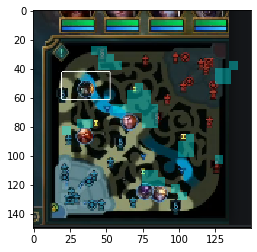

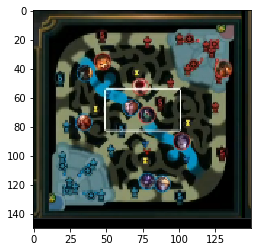

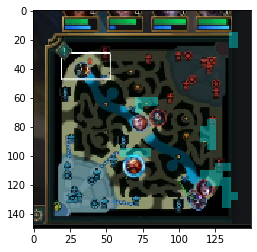

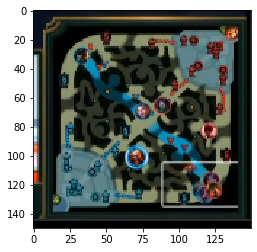

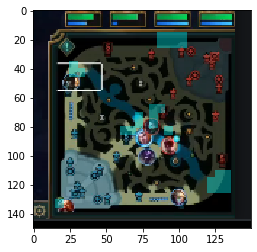

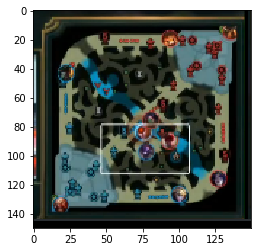

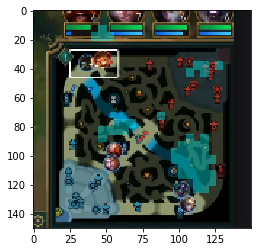

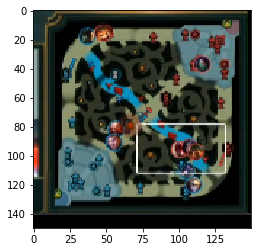

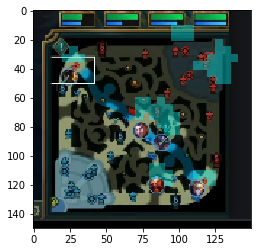

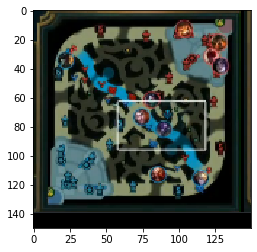

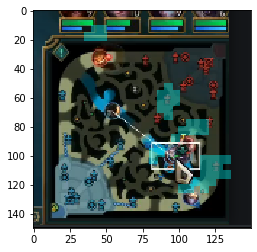

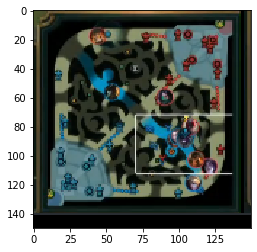

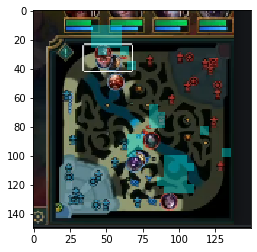

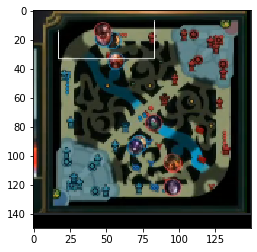

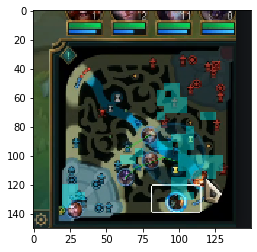

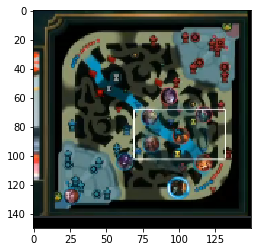

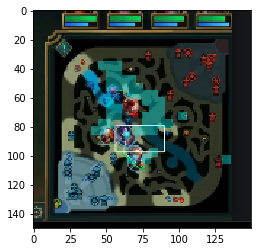

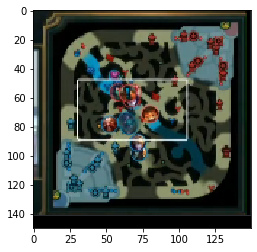

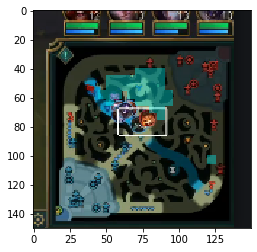

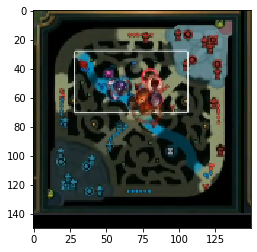

In [3]:
grid_size = 5
def draw_grid(draw, grids):
    for g in grids:
        fill = (0, 255, 255, 96)
        x = g[0] * grid_size
        y = g[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)

def get_preds(csv_path):
    preds = {}
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader)
        for row in reader:
            preds[row[0]] = [(int(i.split(";")[0]), int(i.split(";")[1])) for i in row[1].split(" ")]
        
        return preds

def get_diff_preds(im, preds_all, preds_team):
    p1 = preds_all[im]
    p1.sort()
    p2 = preds_team[im]
    p2.sort()

    indexes = []
    for p in p2:
        min_dst = 9999
        min_index = 0
        for i in range(len(p1)):
            q = p1[i]
            diff = (p[0]-q[0])**2 + (p[1]-q[1])**2
            if diff < min_dst:
                min_dst = diff
                min_index = i
        indexes.append(min_index)
        

    indexes = list(set(indexes))
    indexes.sort(reverse=True)
    for j in indexes:
        p1.pop(j)

    return p1

def get_all_preds():
    preds = {}
    for game in os.listdir("./games"):
        print(game)
        preds_full = get_preds(f"./games/{game}/full/full_{game}.csv")
        preds_team = get_preds(f"./games/{game}/team/team_{game}.csv")
        for k, v in preds_team.items():
            if ".csv" in k:
                continue
            k = k.replace(".png", "")
            try:
                grids = get_diff_preds(k, preds_full, preds_team)
            except KeyError:
                continue
            preds[k] = grids
        break
    return preds

def preds_to_df(preds):
    values = []
    for k, v in preds.items():
        pos = [f"{val[0]};{val[1]}" for val in v]
        pos = " ".join(pos)
        values.append([k, pos])
        
    df = pd.DataFrame(values, columns=["image_name","tags"])
    df.to_csv("./fog_positions.csv", index=False)
    return values
        
    
def draw_preds(preds, game): 
    images = os.listdir(f"./games/{game}/full/")
    images.sort()
        
    for i in range(0,len(images),130):
        im = images[i].replace(".png", "")
        if ".csv" in im:
            continue
        
        grids = preds[im]

        img = PIL.Image.open(f"./games/ahq_ig_1_worlds_oct_12_2019/team/{im}.png").convert("RGBA")
        overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(overlay)
        draw_grid(draw, grids)
        out = PIL.Image.alpha_composite(img, overlay)
        
        plt.figure()
        plt.imshow(out)
        plt.figure()
        t = PIL.Image.open(f"./games/ahq_ig_1_worlds_oct_12_2019/full/{im}.png").convert("RGBA")
        plt.imshow(t)

preds = get_all_preds()
draw_preds(preds, "ahq_ig_1_worlds_oct_12_2019")
# preds_to_df(preds)[:10]